# Deep Learning
## Practice Projects
# P0: Image Classification
In this project, we'll classify images from the [Flower Color Images Dataset](https://www.kaggle.com/olgabelitskaya/flower-color-images). The content is very simple: 210 images (128x128x3) with 10 species of flowering plants and the file with labels `flower-labels.csv`. Photo files are in the .png format and the labels are the integers.

#### Label => Flower Name
- 0 => phlox 
- 1 => rose 
- 2 => calendula 
- 3 => iris 
- 4 => max chrysanthemum
- 5 => bellflower 
- 6 => viola 
- 7 => rudbeckia laciniata 
- 8 => peony
- 9 => aquilegia

We'll preprocess the images, then train a neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded. 

We are going to apply [Keras: The Python Deep Learning library](https://keras.io/). 

At the end, we'll get to see the neural network's predictions on the sample images.

## Step 0. Style and Libraries
Let's set up a style of the Jupyter notebook and import the software libraries. The command `hide_code` will hide the code cells.

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: aliceblue;} 
a {color: #4876ff; font-family: 'Roboto';} 
h1 {color: #348ABD; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Roboto'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #348ABD; font-family: 'Orbitron';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #4876ff;}      
div.output_stderr pre {background-color: aliceblue;}  
div.output_stderr {background-color: slategrey;}                        
</style>
<script>
code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    };
    code_show = !code_show;
} 
$(document).ready(code_display);
</script>
<form action="javascript: code_display()">
<input style="color: #348ABD; background: aliceblue; opacity: 0.8;" \ 
type="submit" value="Click to display or hide code cells">
</form>                       

In [2]:
hide_code = ''
import numpy as np 
import pandas as pd

from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

Using TensorFlow backend.


##  Step 1. Load and Explore the Data
Run the following cell to download the dataset.

In [3]:
hide_code
# Function for processing an image
def image_to_tensor(img_path):
    img = keras_image.load_img("data/flower_images/" + img_path, target_size=(128, 128))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)
# Function for creating the data tensor
def data_to_tensor(img_paths):
    list_of_tensors = [image_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True 
# Load the data
data = pd.read_csv("data/flower_images/flower_labels.csv")
files = data['file']
targets = data['label'].as_matrix()
tensors = data_to_tensor(files);

100%|██████████| 210/210 [00:02<00:00, 75.74it/s]


Run the following cell to display the data shapes

In [4]:
hide_code
# Print the shape
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)

Tensor shape: (210, 128, 128, 3)
Target shape (210,)


We can create a list of flower names and display image examples.

In [5]:
hide_code
# Create the name list
names = ['phlox', 'rose', 'calendula', 'iris', 'max chrysanthemum', 
         'bellflower', 'viola', 'rudbeckia laciniata', 'peony', 'aquilegia']

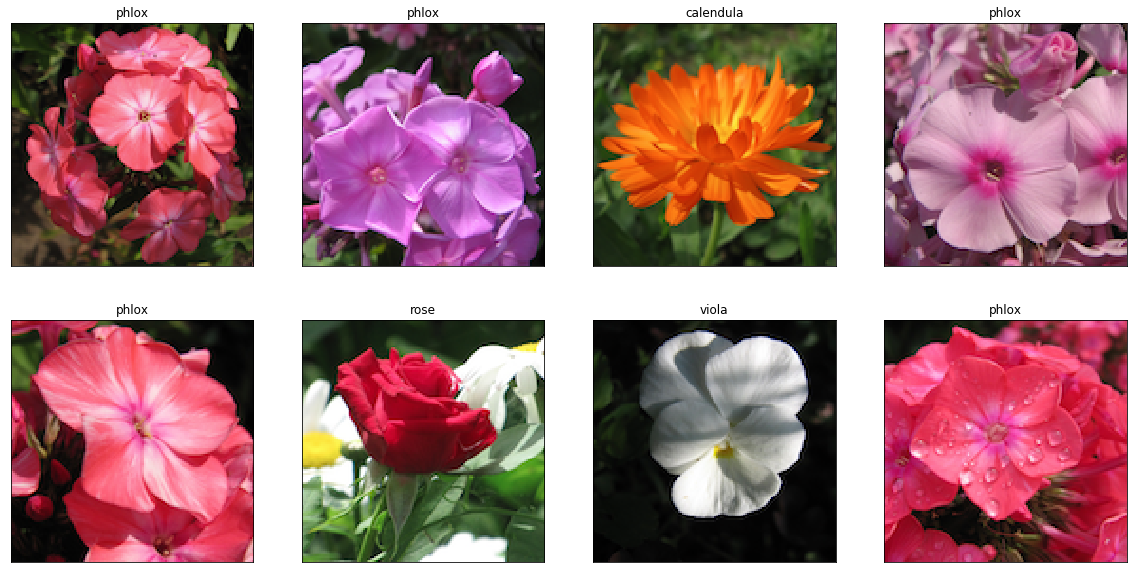

In [6]:
hide_code
# Read from files and display images using OpenCV
def display_images(img_path, ax):
    img = cv2.imread("data/flower_images/" + img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(20, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[], title=names[targets[i]])
    display_images(files[i], ax)

## Step 2. Save and Load the Data

The data tensors can be saved in the appropriate format of files `.h5`.

In [7]:
hide_code
# Create the tensor file
with h5py.File('FlowerColorImages.h5', 'w') as f:
    f.create_dataset('images', data = tensors)
    f.create_dataset('labels', data = targets)
    f.close()

If we decide to come back to this notebook or have to restart it, we can start here.

In [8]:
hide_code
# Read the h5 file
f = h5py.File('FlowerColorImages.h5', 'r')

# List all groups
keys = list(f.keys())
keys

['images', 'labels']

In [9]:
hide_code
# Create tensors and targets
tensors = np.array(f[keys[0]])
targets = np.array(f[keys[1]])
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)

Tensor shape: (210, 128, 128, 3)
Target shape (210,)


## Step 3. Implement Preprocess Functions
### Normalize
In the cell below, normalize the image `tensors`, and return them as a normalized Numpy array.

In [10]:
hide_code
# TODO: normalize the tensors
tensors = tensors.astype('float32')/255

### One-hot encode
Now we'll implement the one-hot encoding function [`to_categorical`](https://keras.io/utils/).

In [11]:
hide_code
# TODO: one-hot encode the targets
targets = to_categorical(targets, 10)

### Split 
Apply the function [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and split the data into training and testing sets. Set up the size of the testing set - 10%.

In [12]:
hide_code
# TODO: split the data
x_train, x_test, y_train, y_test = train_test_split(tensors, targets, 
                                                    test_size = 0.1, 
                                                    random_state = 1)

Let's pring the shape of these data sets.

In [13]:
hide_code
# Print the shape
print ("Training tensor's shape:", x_train.shape)
print ("Training target's shape", y_train.shape)
print ("Testing tensor's shape:", x_test.shape)
print ("Testing target's shape", y_test.shape)

Training tensor's shape: (189, 128, 128, 3)
Training target's shape (189, 10)
Testing tensor's shape: (21, 128, 128, 3)
Testing target's shape (21, 10)


We can display an image example from the training set.

Label:  iris


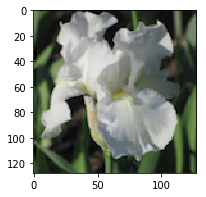

In [14]:
hide_code
# Read and display a tensor using Matplotlib
print('Label: ', names[np.argmax(y_train[1])])
plt.figure(figsize=(3,3))
plt.imshow((x_train[1]));

## Step 4. Create a Model
Define a model architecture and compile the model.

In [15]:
hide_code
def model():
    model = Sequential()
    # TODO: Define a model architecture

    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(96, (5, 5)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(512, activation='tanh'))
    model.add(Dropout(0.25)) 
    
    model.add(Dense(128, activation='tanh'))
    model.add(Dropout(0.25)) 

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

model = model()

## Step 5. Train the Model

In [16]:
hide_code
# train the model
checkpointer = ModelCheckpoint(filepath='weights.best.model.hdf5', 
                               verbose=2, save_best_only=True)
history = model.fit(x_train, y_train, 
                    epochs=100, batch_size=64, verbose=2,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpointer])

Train on 189 samples, validate on 21 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 2.30825, saving model to weights.best.model.hdf5
28s - loss: 2.3011 - acc: 0.1005 - val_loss: 2.3083 - val_acc: 0.1905
Epoch 2/100
Epoch 00001: val_loss improved from 2.30825 to 2.14999, saving model to weights.best.model.hdf5
20s - loss: 2.2422 - acc: 0.1534 - val_loss: 2.1500 - val_acc: 0.1429
Epoch 3/100
Epoch 00002: val_loss improved from 2.14999 to 2.12948, saving model to weights.best.model.hdf5
25s - loss: 2.1194 - acc: 0.2487 - val_loss: 2.1295 - val_acc: 0.0476
Epoch 4/100
Epoch 00003: val_loss improved from 2.12948 to 2.01030, saving model to weights.best.model.hdf5
23s - loss: 2.1316 - acc: 0.2063 - val_loss: 2.0103 - val_acc: 0.2381
Epoch 5/100
Epoch 00004: val_loss improved from 2.01030 to 1.99221, saving model to weights.best.model.hdf5
25s - loss: 2.0341 - acc: 0.2434 - val_loss: 1.9922 - val_acc: 0.1429
Epoch 6/100
Epoch 00005: val_loss improved from 1.99221 to 1.81036, s

Epoch 00060: val_loss improved from 0.94124 to 0.93083, saving model to weights.best.model.hdf5
18s - loss: 0.7335 - acc: 0.7566 - val_loss: 0.9308 - val_acc: 0.5714
Epoch 62/100
Epoch 00061: val_loss did not improve
18s - loss: 0.7636 - acc: 0.7354 - val_loss: 1.0126 - val_acc: 0.7143
Epoch 63/100
Epoch 00062: val_loss improved from 0.93083 to 0.88813, saving model to weights.best.model.hdf5
18s - loss: 0.6344 - acc: 0.7989 - val_loss: 0.8881 - val_acc: 0.7143
Epoch 64/100
Epoch 00063: val_loss improved from 0.88813 to 0.84409, saving model to weights.best.model.hdf5
17s - loss: 0.5988 - acc: 0.7937 - val_loss: 0.8441 - val_acc: 0.7143
Epoch 65/100
Epoch 00064: val_loss did not improve
18s - loss: 0.7548 - acc: 0.7249 - val_loss: 1.0668 - val_acc: 0.6190
Epoch 66/100
Epoch 00065: val_loss did not improve
17s - loss: 0.6556 - acc: 0.8042 - val_loss: 0.8603 - val_acc: 0.7143
Epoch 67/100
Epoch 00066: val_loss did not improve
19s - loss: 0.6158 - acc: 0.7884 - val_loss: 1.0343 - val_acc:

## Step 6. Evaluate ans Save the Model
We should have an accuracy greater than 50%

In [17]:
hide_code
# Load the model with the best validation accuracy
model.load_weights('weights.best.model.hdf5')
# Calculate classification accuracy on the testing set
score = model.evaluate(x_test, y_test)
score

21/21 [==============================] - 0s


[0.73995047807693481, 0.76190477609634399]

In [18]:
hide_code
# Save/reload models
model.save('model.h5')
model = load_model('model.h5')

The model has been saved to disk.

## Step 7. Display Predictions

In [19]:
hide_code
# Model predictions for the testing dataset
y_test_predict = model.predict_classes(x_test)

21/21 [==============================] - 0s


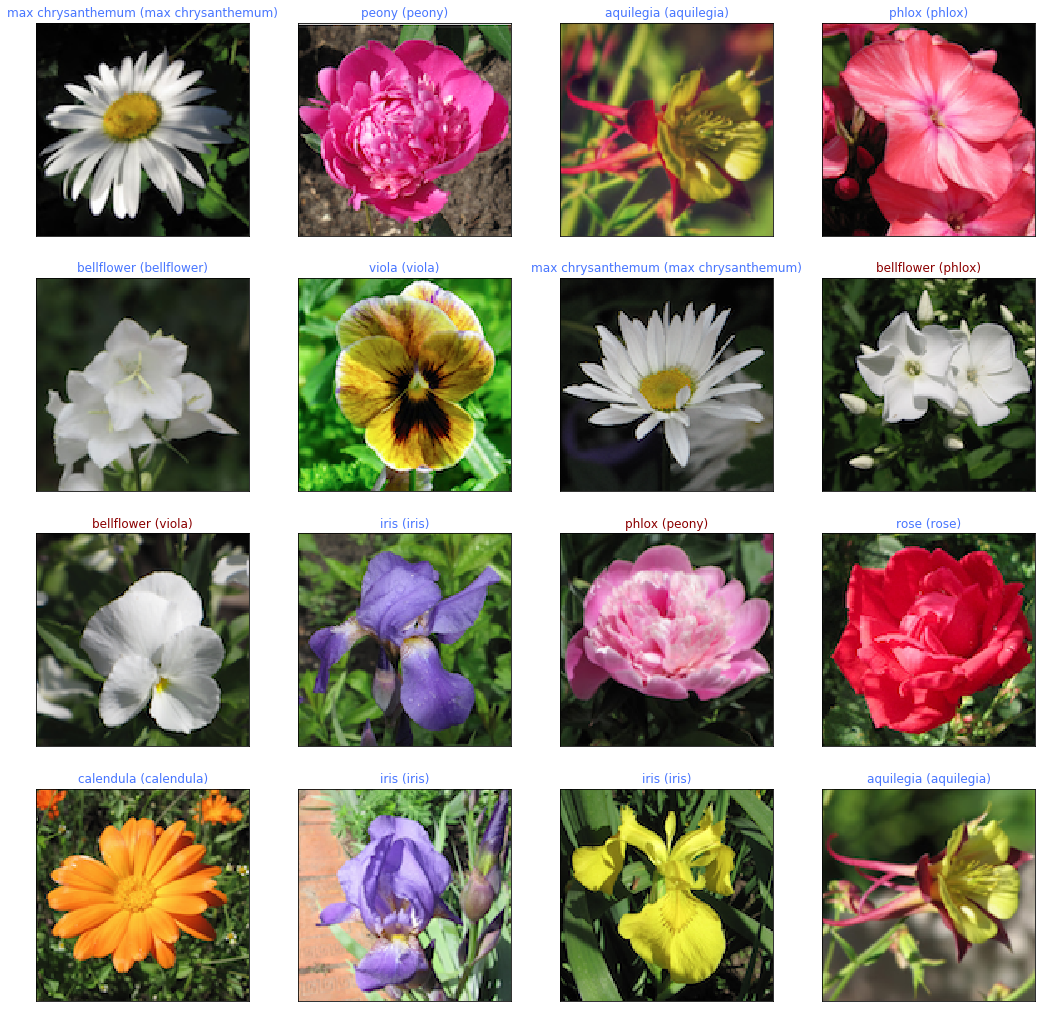

In [21]:
hide_code
# Display true labels and predictions
fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = y_test_predict[idx]
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(names[pred_idx], names[true_idx]),
                 color=("#4876ff" if pred_idx == true_idx else "darkred"))